In [3]:
pip install prophet

     -------------------------------------- 13.3/13.3 MB 235.7 kB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 245.0 kB/s eta 0:00:00
     -------------------------------------- 94.5/94.5 kB 337.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

# Set seed for reproducibility
np.random.seed(0)

# Define parameters
num_days = 365  # One year of data
start_date = datetime(2023, 1, 1)

# Generate date range
dates = [start_date + timedelta(days=i) for i in range(num_days)]

# Generate synthetic data
data = pd.DataFrame({
    'date': dates,
    'product_id': np.random.choice(['P001', 'P002', 'P003'], size=num_days),
    'demand': np.random.poisson(100, size=num_days),         # Random demand around 100 units
    'inventory': np.random.randint(50, 150, size=num_days),  # Random inventory level between 50-150 units
    'lead_time': np.random.randint(1, 7, size=num_days)      # Lead time between 1-6 days
})

# Display the first few rows of the dataset
data.head()

,date,product_id,demand,inventory,lead_time
0,2023-01-01,P001,115,107,3
1,2023-01-02,P002,101,55,3
2,2023-01-03,P001,126,146,6
3,2023-01-04,P002,92,72,2
4,2023-01-05,P002,105,53,5


In [3]:
# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows with missing data (example for demand)
data['demand'].fillna(data['demand'].mean(), inplace=True)

# Convert `date` column to datetime
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

date          0
product_id    0
demand        0
inventory     0
lead_time     0
dtype: int64


In [4]:
# Add time-based features (year, month, day of week, etc.)
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# Add lag features to capture past demand trends (e.g., demand from last week)
data['demand_lag_1'] = data['demand'].shift(1)
data['demand_lag_7'] = data['demand'].shift(7)

In [5]:
# Build Demand Forecasting Model

#Train and Test

# Split into train and test sets
train_size = int(0.8 * len(data))
train = data[:train_size]
test = data[train_size:]



In [8]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

In [10]:
# ARIMA Model for Time Series Forecasting
from sklearn.metrics import mean_absolute_error, mean_squared_error
arima_model = ARIMA(train['demand'], order=(5,1,0))  # Order (p,d,q) based on your data's nature
arima_result = arima_model.fit()

# Forecast demand for the test set
arima_forecast = arima_result.forecast(steps=len(test))

# Evaluate ARIMA model performance
mae = mean_absolute_error(test['demand'], arima_forecast)
rmse = np.sqrt(mean_squared_error(test['demand'], arima_forecast))
print(f'ARIMA MAE: {mae}, RMSE: {rmse}')


ARIMA MAE: 7.514967481767943, RMSE: 9.592983646531245


In [12]:
# Import Prophet
from prophet import Prophet

# Prepare data for Prophet model
prophet_data = train[['date', 'demand']].rename(columns={'date': 'ds', 'demand': 'y'})

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Create a DataFrame with future dates
future_dates = prophet_model.make_future_dataframe(periods=len(test))

# Predict using the Prophet model
prophet_forecast = prophet_model.predict(future_dates)

# Extract the forecasted demand for the test set dates
prophet_demand_forecast = prophet_forecast['yhat'][-len(test):].values

# Evaluate Prophet model performance
mae = mean_absolute_error(test['demand'], prophet_demand_forecast)
rmse = np.sqrt(mean_squared_error(test['demand'], prophet_demand_forecast))
print(f'Prophet MAE: {mae}, RMSE: {rmse}')


11:25:49 - cmdstanpy - INFO - Chain [1] start processing
11:25:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 7.569862775997655, RMSE: 9.405037050075217


In [13]:
#Now We are Calculating Inventory Optimization Metrics
# Assuming lead time and standard deviation of demand are provided
average_demand = train['demand'].mean()
lead_time = data['lead_time'].mean()  # Replace with actual lead time
demand_std_dev = train['demand'].std()
service_level = 1.65  # Service level for 95% confidence

# Calculate Safety Stock
safety_stock = service_level * demand_std_dev * np.sqrt(lead_time)

# Calculate Reorder Point
reorder_point = (average_demand * lead_time) + safety_stock
print(f'Reorder Point: {reorder_point}, Safety Stock: {safety_stock}')


Reorder Point: 391.8705537610106, Safety Stock: 31.39462957260751


In [14]:
#Economic Order Quantity (EOQ)
# Define variables for EOQ calculation
annual_demand = average_demand * 365  # Annual demand estimate
ordering_cost = 50  # Cost per order
holding_cost_per_unit = 2  # Holding cost per unit

# EOQ formula
EOQ = np.sqrt((2 * annual_demand * ordering_cost) / holding_cost_per_unit)
print(f'Economic Order Quantity (EOQ): {EOQ}')

Economic Order Quantity (EOQ): 1350.2777492056957


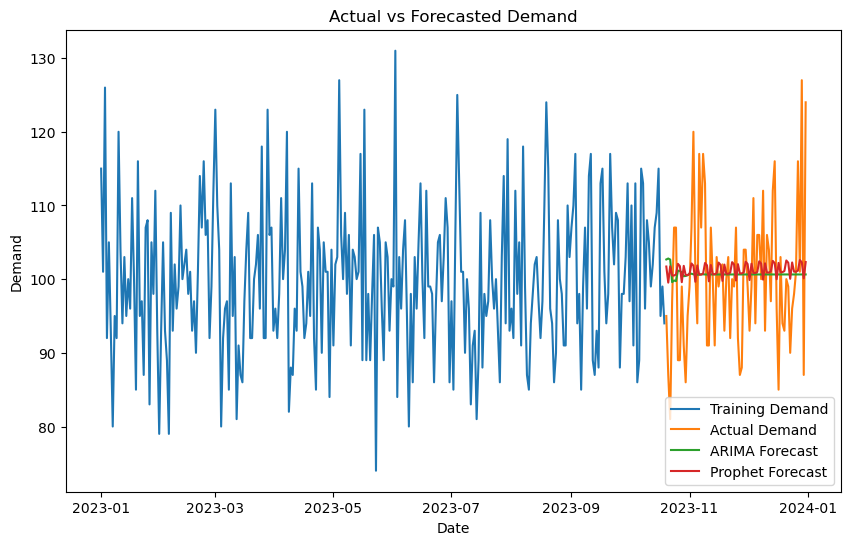

In [16]:
#Scenario Analysis and Visualization

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Scenario Analysis and Visualization

# Plot actual vs. forecasted demand
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['demand'], label='Training Demand')
plt.plot(test['date'], test['demand'], label='Actual Demand')
plt.plot(test['date'], arima_forecast, label='ARIMA Forecast')
plt.plot(test['date'], prophet_demand_forecast, label='Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Forecasted Demand')
plt.legend()
plt.show()


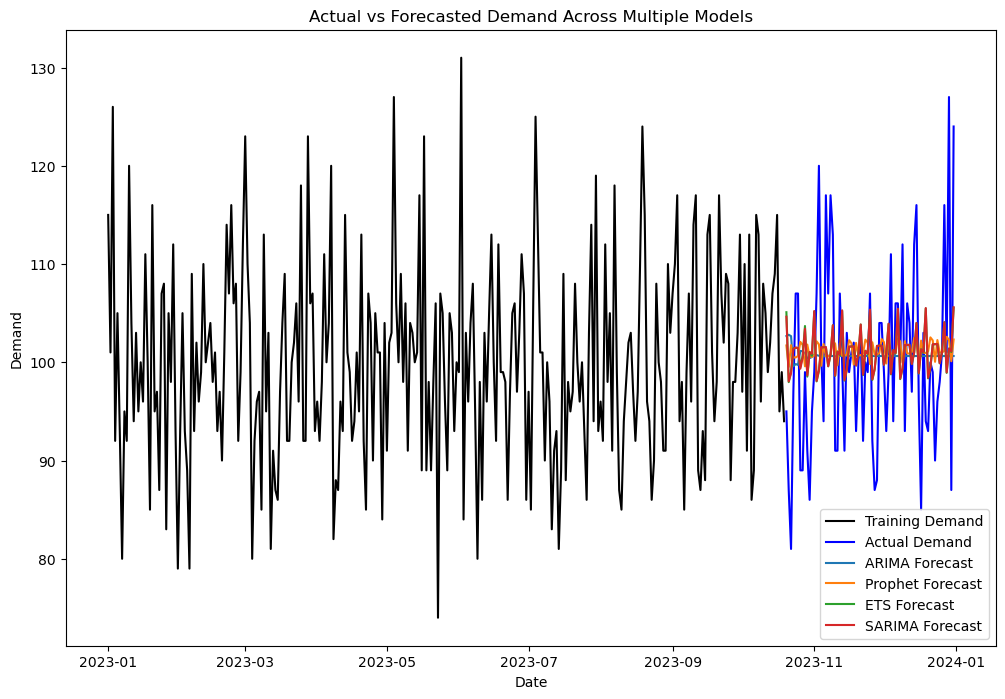

In [17]:
# Import necessary libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Prepare lists to store forecasts for easy visualization later
forecasts = {
    'ARIMA': arima_forecast,
    'Prophet': prophet_demand_forecast
}

# ---- Exponential Smoothing (ETS) ----
# Define and fit the Exponential Smoothing model
ets_model = ExponentialSmoothing(
    train['demand'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit()

# Forecast demand for the test set
ets_forecast = ets_model.forecast(steps=len(test))
forecasts['ETS'] = ets_forecast

# ---- SARIMA ----
# Define and fit the SARIMA model
sarima_model = SARIMAX(
    train['demand'], 
    order=(1, 1, 1),            # ARIMA order
    seasonal_order=(1, 1, 1, 12)  # Seasonal order
).fit()

# Forecast demand for the test set
sarima_forecast = sarima_model.forecast(steps=len(test))
forecasts['SARIMA'] = sarima_forecast

# ---- Visualize All Forecasts ----

# Plot actual vs. forecasted demand for each model
plt.figure(figsize=(12, 8))
plt.plot(train['date'], train['demand'], label='Training Demand', color='black')
plt.plot(test['date'], test['demand'], label='Actual Demand', color='blue')

# Plot each forecast
for model_name, forecast in forecasts.items():
    plt.plot(test['date'], forecast, label=f'{model_name} Forecast')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Forecasted Demand Across Multiple Models')
plt.legend()
plt.show()


In [18]:
# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate and print MAE and RMSE for each model
for model_name, forecast in forecasts.items():
    mae = mean_absolute_error(test['demand'], forecast)
    rmse = np.sqrt(mean_squared_error(test['demand'], forecast))
    print(f'{model_name} MAE: {mae}, RMSE: {rmse}')

ARIMA MAE: 7.514967481767943, RMSE: 9.592983646531245
Prophet MAE: 7.569862775997655, RMSE: 9.405037050075217
ETS MAE: 7.254193825675135, RMSE: 9.115720255859655
SARIMA MAE: 7.242300335918612, RMSE: 9.101192523917641


In [19]:
# Prepare the data for models that require scaled input (like LSTM)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[['demand']])
scaled_test = scaler.transform(test[['demand']])

In [20]:
# Xg Boost
from xgboost import XGBRegressor

# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror')
xgb_model.fit(np.arange(len(scaled_train)).reshape(-1, 1), scaled_train)

# Forecast demand for the test set using XGBoost
xgb_forecast = xgb_model.predict(np.arange(len(scaled_train), len(scaled_train) + len(scaled_test)).reshape(-1, 1))
xgb_forecast = scaler.inverse_transform(xgb_forecast.reshape(-1, 1)).flatten()
forecasts['XGBoost'] = xgb_forecast


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


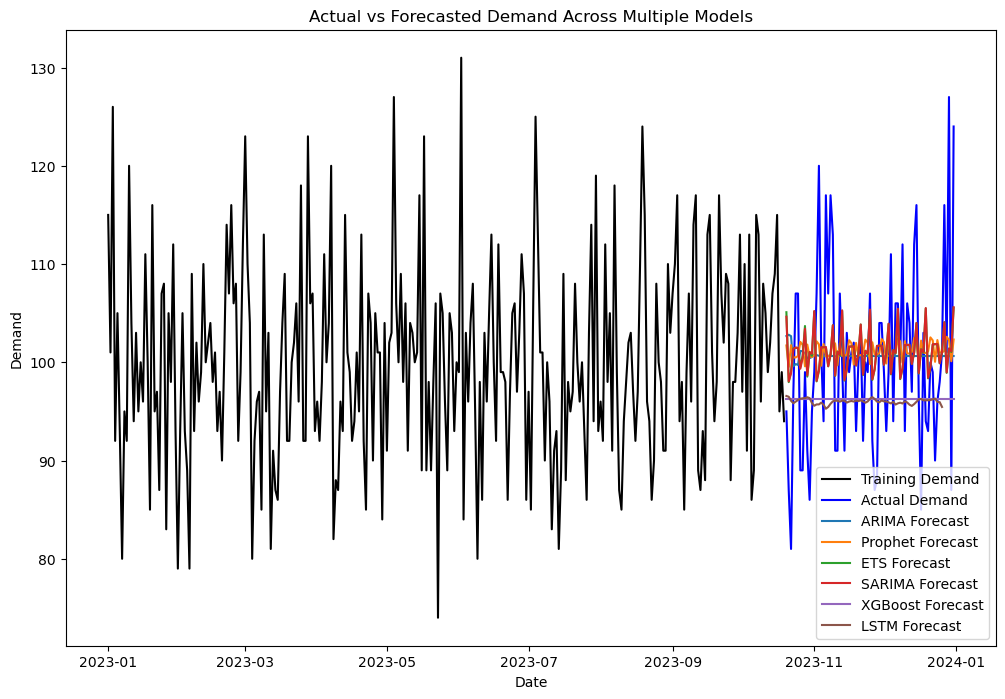

In [22]:
# Ensure time_steps do not exceed the test set length
time_steps = min(time_steps, len(scaled_test))

# Generate test sequences with time steps
X_test = []
for i in range(time_steps, len(scaled_test)):
    X_test.append(scaled_test[i - time_steps:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Forecast demand using LSTM
lstm_forecast = lstm_model.predict(X_test)

# Reshape lstm_forecast to align with the test set length if necessary
lstm_forecast = scaler.inverse_transform(lstm_forecast.reshape(-1, 1)).flatten()

# If the forecasted values are fewer than the test set length, pad with NaNs
if len(lstm_forecast) < len(test):
    lstm_forecast = np.concatenate([lstm_forecast, np.full(len(test) - len(lstm_forecast), np.nan)])

forecasts['LSTM'] = lstm_forecast

# Visualize and evaluate as previously
plt.figure(figsize=(12, 8))
plt.plot(train['date'], train['demand'], label='Training Demand', color='black')
plt.plot(test['date'], test['demand'], label='Actual Demand', color='blue')

# Plot each forecast
for model_name, forecast in forecasts.items():
    plt.plot(test['date'], forecast, label=f'{model_name} Forecast')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Forecasted Demand Across Multiple Models')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate and print MAE and RMSE for each model, handling NaNs
for model_name, forecast in forecasts.items():
    # Remove NaN values from the forecast and the corresponding parts in the test set
    valid_forecast = forecast[~np.isnan(forecast)]
    valid_actual = test['demand'].values[:len(valid_forecast)]  # Match the length
    
    # Calculate MAE and RMSE for valid values only
    mae = mean_absolute_error(valid_actual, valid_forecast)
    rmse = np.sqrt(mean_squared_error(valid_actual, valid_forecast))
    print(f'{model_name} MAE: {mae:.2f}, RMSE: {rmse:.2f}')

ARIMA MAE: 7.51, RMSE: 9.59
Prophet MAE: 7.57, RMSE: 9.41
ETS MAE: 7.25, RMSE: 9.12
SARIMA MAE: 7.24, RMSE: 9.10
XGBoost MAE: 7.88, RMSE: 10.21
LSTM MAE: 7.29, RMSE: 9.12


ARIMA - MAE: 7.51, RMSE: 9.59
Prophet - MAE: 7.57, RMSE: 9.41
ETS - MAE: 7.25, RMSE: 9.12
SARIMA - MAE: 7.24, RMSE: 9.10
XGBoost - MAE: 7.88, RMSE: 10.21
LSTM - MAE: 7.29, RMSE: 9.12


C:\Users\91938\AppData\Local\Temp\ipykernel_6752\712455887.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(models, rotation=45, ha='right')
C:\Users\91938\AppData\Local\Temp\ipykernel_6752\712455887.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(models, rotation=45, ha='right')


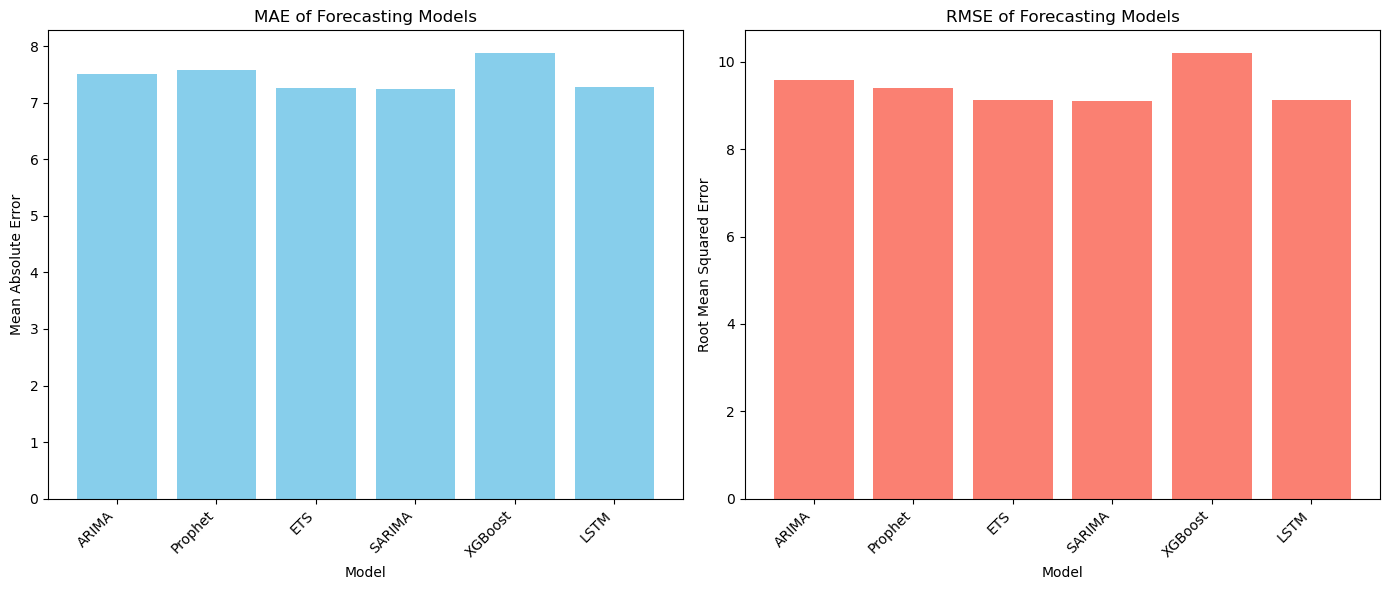


Best model based on MAE: SARIMA with MAE of 7.24
Best model based on RMSE: SARIMA with RMSE of 9.10


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize dictionaries to store MAE and RMSE for each model
mae_scores = {}
rmse_scores = {}

# Evaluate and store MAE and RMSE for each model
for model_name, forecast in forecasts.items():
    # Remove NaN values from the forecast and align with the actual test values
    valid_forecast = forecast[~np.isnan(forecast)]
    valid_actual = test['demand'].values[:len(valid_forecast)]
    
    # Calculate MAE and RMSE
    mae = mean_absolute_error(valid_actual, valid_forecast)
    rmse = np.sqrt(mean_squared_error(valid_actual, valid_forecast))
    
    # Store the results
    mae_scores[model_name] = mae
    rmse_scores[model_name] = rmse
    print(f'{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# Identify the best model based on lowest MAE
best_model_mae = min(mae_scores, key=mae_scores.get)
best_model_rmse = min(rmse_scores, key=rmse_scores.get)

# Plotting the MAE and RMSE scores for comparison
models = list(mae_scores.keys())
mae_values = list(mae_scores.values())
rmse_values = list(rmse_scores.values())

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# MAE Bar Plot
ax[0].bar(models, mae_values, color='skyblue')
ax[0].set_title('MAE of Forecasting Models')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_xticklabels(models, rotation=45, ha='right')

# RMSE Bar Plot
ax[1].bar(models, rmse_values, color='salmon')
ax[1].set_title('RMSE of Forecasting Models')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Root Mean Squared Error')
ax[1].set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Summary of best models
print(f"\nBest model based on MAE: {best_model_mae} with MAE of {mae_scores[best_model_mae]:.2f}")
print(f"Best model based on RMSE: {best_model_rmse} with RMSE of {rmse_scores[best_model_rmse]:.2f}")

In [26]:
# Save forecast results and metrics to CSV
forecast_results = pd.DataFrame({
    'Date': test['date'],
    'Actual_Demand': test['demand'],
    'Forecasted_Demand': arima_forecast
})
forecast_results.to_csv('forecast_results.csv', index=False)

# Display key metrics
print(f"Safety Stock: {safety_stock}, Reorder Point: {reorder_point}, EOQ: {EOQ}")

Safety Stock: 31.39462957260751, Reorder Point: 391.8705537610106, EOQ: 1350.2777492056957
